In [172]:
import math
import networkx as nx
import igraph as ig
import leidenalg as la
from ipysigma import Sigma, SigmaGrid
from pelote import graph_to_edges_dataframe, read_graphology_json, multiscale_backbone, floatsam_threshold_learner, global_threshold_sparsification
from pelote.classes import BFSQueue
from pelote.projection import bfs_from_node as bfs_from_node_directed
from fog.metrics import jaccard_similarity, cosine_similarity

Sigma.set_defaults(max_categorical_colors=25)

In [2]:
def bfs_from_node(graph, source, limit=1):
    queue = BFSQueue(graph)
    queue.append(source, (source, 0))

    while len(queue) != 0:
        node, depth = queue.popleft()
        
        if depth > 0:
            yield node, depth

        if depth >= limit:
            continue

        for neighbor in graph.neighbors(node):
            if neighbor == source:
                continue
                
            queue.append(neighbor, (neighbor, depth + 1))

In [7]:
def wdist(g):
    return graph_to_edges_dataframe(g).weight.plot.hist()

In [203]:
def directed_selfsim(g: nx.DiGraph, k=10, depth=2) -> nx.Graph:
    h = nx.Graph()
    # k = math.ceil(math.log2(len(g)))

    vectors = {}

    for n1 in g:
        v = set()

        for n2, d in bfs_from_node_directed(g, n1, limit=depth):
            v.add((True, n2, d))

        for n2, d in bfs_from_node_directed(g, n1, limit=depth, reverse=True):
            v.add((False, n2, d))

        vectors[n1] = v

    nodes = list(vectors)

    for i in range(len(nodes)):
        n1 = nodes[i]
        h.add_node(n1, label=g.nodes[n1].get("label"))
        v1 = vectors[n1]

        candidates = []

        for j in range(i + 1, len(nodes)):
            n2 = nodes[j]

            # if g.has_edge(n1, n2):
            #     continue
            
            v2 = vectors[n2]

            u = set()
            i = set()

            v1l = 0
            v2l = 0

            for n in v1:
                if n[1] == n2:
                    continue

                u.add(n)
                v1l += 1

                if n in v2:
                    i.add(n)

            for n in v2:
                if n[1] == n1:
                    continue

                v2l += 1
                u.add(n)

            s = len(i) / min(v1l, v2l)

            if s > 0:
                candidates.append((s, n2))

        for s, n2 in sorted(candidates, reverse=True)[:k]:
            h.add_edge(n1, n2, weight=s)
            
    return h

In [50]:
math.ceil(math.log(len(corpus))), corpus.size() / corpus.order()

(7, 49.845238095238095)

In [8]:
corpus = read_graphology_json("./polarisation.json")

In [204]:
# 7
h_corpus = directed_selfsim(corpus, k=7, depth=1)
backup = h_corpus

In [173]:
h_corpus = backup

In [177]:
threshold = floatsam_threshold_learner(h_corpus)
threshold

0.6500000000000004

In [168]:
h_corpus = multiscale_backbone(h_corpus, alpha=0.2, keep_connected=False)

In [179]:
h_corpus = global_threshold_sparsification(h_corpus, threshold)

<Axes: ylabel='Frequency'>

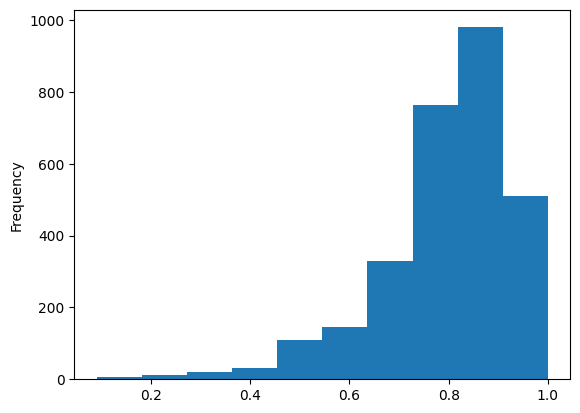

In [205]:
wdist(h_corpus)

In [207]:
ig_h_corpus = ig.Graph.from_networkx(h_corpus)
partition = la.find_partition(ig_h_corpus, la.CPMVertexPartition, resolution_parameter=0.08)
partition

In [157]:
def louvain(g: nx.Graph):
    ig_g = ig.Graph.from_networkx(g)
    partition = la.find_partition(ig_g, la.ModularityVertexPartition)
    return {n: m for n, m in zip(g, partition._membership)}

In [208]:
w = SigmaGrid(
    h_corpus,
    node_size=corpus.degree,
    default_node_border_size=1,
    default_node_border_color="white",
    views=[
        {"name": "louvain", "node_color": louvain(h_corpus)},
        {"name": "leiden", "node_color": partition},
        {"name": "sbm", "node_color": lambda u: corpus.nodes[u]["wheel_subcategory"]}
    ],
    edge_size="weight",
    edge_size_range=(0.5, 3),
    show_all_labels=False,
    columns=3
)
w

In [209]:
SigmaGrid(corpus, node_size=corpus.degree, node_label_size=corpus.degree, node_label_size_range=(4, 12), views=[
    {"node_color": {n: m for n, m in zip(h_corpus, partition._membership)}, "name": "Selfsim"},
    {"node_color": "louvain", "node_metrics": ["louvain"], "name": "Louvain"},
    {"node_color": "wheel_subcategory", "name": "Wheel"},
], default_node_border_color="white", columns=3)

In [73]:
def undirected_selfsim(g: nx.Graph, k=10, depth=2) -> nx.Graph:
    h = nx.Graph()
    # k = math.ceil(math.log2(len(g)))

    vectors = {}

    for n1 in g:
        v = set()

        for t in bfs_from_node(g, n1, limit=depth):
            v.add(t)

        vectors[n1] = v

    nodes = list(vectors)

    for i in range(len(nodes)):
        n1 = nodes[i]
        h.add_node(n1, label=g.nodes[n1].get("label"))
        v1 = vectors[n1]

        candidates = []

        for j in range(i + 1, len(nodes)):
            n2 = nodes[j]

            # if g.has_edge(n1, n2):
            #     continue
            
            v2 = vectors[n2]

            u = set()
            i = set()

            for n in v1:
                if n[0] == n2:
                    continue

                u.add(n)

                if n in v2:
                    i.add(n)

            for n in v2:
                if n[0] == n1:
                    continue

                u.add(n)

            if len(u) == 0:
                continue

            s = len(i) / len(u)

            if s > 0:
                candidates.append((s, n2))

        for s, n2 in sorted(candidates, reverse=True)[:k]:
            h.add_edge(n1, n2, weight=s)
            
    return h

In [74]:
eurosis = read_graphology_json("./eurosis.json")

In [75]:
simple = nx.Graph()

for node, a in eurosis.nodes(data=True):
    simple.add_node(node, **a)

for u, v in eurosis.edges():
    simple.add_edge(u, v)

eurosis = simple
eurosis.order()

1285

In [83]:
h_eurosis = undirected_selfsim(eurosis, depth=3)

<Axes: ylabel='Frequency'>

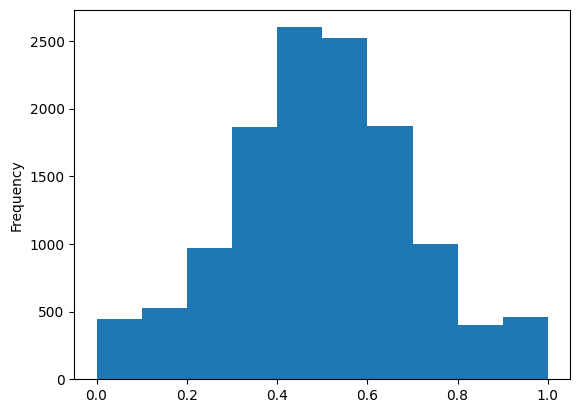

In [84]:
wdist(h_eurosis)

In [85]:
w = Sigma(
    h_eurosis,
    node_size=eurosis.degree,
    default_node_border_size=1,
    default_node_border_color="white",
    node_color="louvain",
    node_metrics=[{"name": "louvain", "resolution": 1.2}],
    edge_size="weight",
    edge_size_range=(0.5, 3),
)
w

Sigma(nx.Graph with 1,285 nodes and 12,667 edges)

In [86]:
SigmaGrid(eurosis, node_size=eurosis.degree, views=[
    {"node_color": w.node_metrics["louvain"]["result"], "name": "Selfsim"},
    {"node_color": "louvain", "node_metrics": ["louvain"], "name": "Louvain"},
], default_node_border_color="black", columns=3)